In [1]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

bias = 10

# Wykorzystajmy funkcję make_regression do wygenerowania danych regresji.
# - n_samples: Liczba próbek danych.
# - n_features: Liczba cech w danych (jedna cecha).
# - n_targets: Liczba celów (jeden cel).
# - noise: Poziom szumu w danych.
# - bias: Stała przesunięcia w regresji.
# - coef: Określa, czy zwracać współczynniki regresji.
# - random_state: Ustawia ziarno generatora liczb losowych dla reprodukowalności wyników.
X_numpy, y_numpy, coef = make_regression(
    n_samples=5000,
    n_features=1,
    n_targets=1,
    noise=10,
    bias=bias,
    coef=True,
    random_state=42
)

ModuleNotFoundError: No module named 'sklearn'

In [2]:

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X_numpy, y_numpy, c='c', marker='o', alpha=0.2)

ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Zależność między zmiennymi', size=18, weight='bold')


plt.show()

NameError: name 'plt' is not defined

In [ ]:

# Importujemy biblioteki PyTorch.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

# Definiujemy klasę RegressionDataset, która dziedziczy po klasie Dataset z PyTorch.


class RegressionDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()

        # Konwertujemy dane X i y na tensory PyTorch typu float32.
        self.X = torch.from_numpy(X.astype('float32'))
        self.y = torch.from_numpy(y.astype('float32'))

    def __len__(self):
        # Zwraca liczbę próbek w zbiorze danych.
        return len(self.X)

    def __getitem__(self, index):
        # Zwraca pojedynczą próbkę z zestawu danych w formie krotki (cecha, etykieta).
        return self.X[index], self.y[index].unsqueeze(0)


# Tworzymy instancję klasy RegressionDataset, przekazując dane X_numpy i y_numpy.
dataset = RegressionDataset(X_numpy, y_numpy)

In [ ]:

# Podział na zbiór treningowy i testowy
train_dataset, test_dataset = random_split(dataset, lengths=[0.8, 0.2])

In [ ]:
# Tworzy DataLoader dla danych treningowych.
train_loader = DataLoader(
    dataset=train_dataset,  # Tutaj powinien być zbiór danych treningowych.
    batch_size=64,  # Określa rozmiar wsadu (batch size).
    shuffle=True  # Mieszanie danych przed każdą epoką treningową.
)

# Tworzy DataLoader dla danych testowych.
test_loader = DataLoader(
    dataset=test_dataset,  # Tutaj powinien być zbiór danych testowych.
    batch_size=64,  # Określa rozmiar wsadu (batch size) podczas testowania.
    # Mieszanie danych przed każdym przejściem przez dane testowe.
    shuffle=True
)

In [ ]:

# Definiujemy klasę LinearRegressionSimple, która dziedziczy po nn.Module z PyTorch.
class LinearRegressionSimple(nn.Module):
    def __init__(self, in_features=1, out_features=1):
        super().__init__()

        # Tworzy warstwę liniową (regresji liniowej) o określonej liczbie cech wejściowych i wyjściowych.
        self.linear = nn.Linear(
            in_features=in_features,
            out_features=out_features
        )

    def forward(self, x):
        # Definiujemy forward pass modelu. Tutaj model po prostu przekształca dane wejściowe przez warstwę liniową.
        return self.linear(x)

In [ ]:

model = LinearRegressionSimple()

In [ ]:

# Definiujemy kryterium straty (Mean Squared Error) - średni błąd kwadratowy.
criterion = nn.MSELoss()

# Definiujemy optymalizator Stochastic Gradient Descent (SGD).
# Parametry optymalizatora to parametry modelu (model.parameters()) i współczynnik uczenia (lr=0.001).
optimizer = optim.SGD(params=model.parameters(), lr=0.001)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cpu'

In [ ]:

train_losses = []
val_losses = []

In [ ]:

# Definiuj funkcję train, która jest odpowiedzialna za uczenie modelu.
def train(model, train_loader, criterion, optimizer, epoch, num_epochs):
    # Ustaw model w tryb treningowy.
    model.train()
    train_loss = 0.0

    # Iteruj przez dane treningowe za pomocą DataLoader.
    for inputs, targets in train_loader:
        # Przenoś dane na urządzenie (np. GPU, jeśli jest dostępne).
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Przewiń dane przez model.
        outputs = model(inputs)

        # Oblicz stratę (loss) między przewidywaniami a rzeczywistymi celami.
        loss = criterion(outputs, targets)

        # Wyzeruj gradienty w optymalizatorze.
        optimizer.zero_grad()

        # Akumuluj stratę.
        train_loss += loss.item()

        # Oblicz gradienty straty wstecz (backpropagation).
        loss.backward()

        # Zaktualizuj wagi modelu na podstawie gradientów.
        optimizer.step()

    # Oblicz średnią stratę na podstawie wszystkich wsadów (batches) w epoce.
    avg_loss = train_loss / len(train_loader)

    # Wyświetl informacje o postępie treningu.
    print(
        f'Epoch [{epoch + 1:03}/{num_epochs:03}] | Train Loss: {avg_loss:.4f}')

    # Zapisz średnią stratę do listy, aby można ją było później zwizualizować.
    train_losses.append(avg_loss)

In [ ]:
# Definiuj funkcję validate, która jest odpowiedzialna za walidację modelu.
def validate(model, val_loader, criterion, device):
    # Ustaw model w tryb ewaluacji (bez uczenia).
    model.eval()
    val_loss = 0.0

    # Wyłącz obliczanie gradientów (nie jest potrzebne podczas walidacji).
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Przenoś dane na urządzenie (np. GPU, jeśli jest dostępne).
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Przewiń dane przez model.
            outputs = model(inputs)

            # Oblicz stratę (loss) między przewidywaniami a rzeczywistymi celami.
            loss = criterion(outputs, targets)

            # Akumuluj stratę.
            val_loss += loss.item()

    # Oblicz średnią stratę na podstawie wszystkich wsadów (batches) w danych walidacyjnych.
    avg_loss = val_loss / len(val_loader)

    # Wyświetl informacje o wyniku walidacji.
    print(f'Validation Loss: {avg_loss:.4f}')

    # Zapisz średnią stratę do listy, aby można ją było później zwizualizować.
    val_losses.append(avg_loss)

In [ ]:

# Trenowanie
num_epochs = 30
model.to(device)
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, epoch, num_epochs)
    validate(model, test_loader, criterion, device)

Epoch [001/030] | Train Loss: 468.2444
Validation Loss: 414.4543
Epoch [002/030] | Train Loss: 387.2033
Validation Loss: 342.5464
Epoch [003/030] | Train Loss: 323.6309
Validation Loss: 288.8771
Epoch [004/030] | Train Loss: 275.2298
Validation Loss: 249.6941
Epoch [005/030] | Train Loss: 237.6324
Validation Loss: 214.5647
Epoch [006/030] | Train Loss: 207.6105
Validation Loss: 188.5558
Epoch [007/030] | Train Loss: 183.8744
Validation Loss: 168.6976
Epoch [008/030] | Train Loss: 166.1577
Validation Loss: 153.6440
Epoch [009/030] | Train Loss: 151.7277
Validation Loss: 143.7291
Epoch [010/030] | Train Loss: 141.3409
Validation Loss: 133.2933
Epoch [011/030] | Train Loss: 133.2767
Validation Loss: 127.6078
Epoch [012/030] | Train Loss: 126.5755
Validation Loss: 122.3873
Epoch [013/030] | Train Loss: 121.5837
Validation Loss: 116.7919
Epoch [014/030] | Train Loss: 117.5823
Validation Loss: 113.4817
Epoch [015/030] | Train Loss: 114.6139
Validation Loss: 113.4897
Epoch [016/030] | Train L

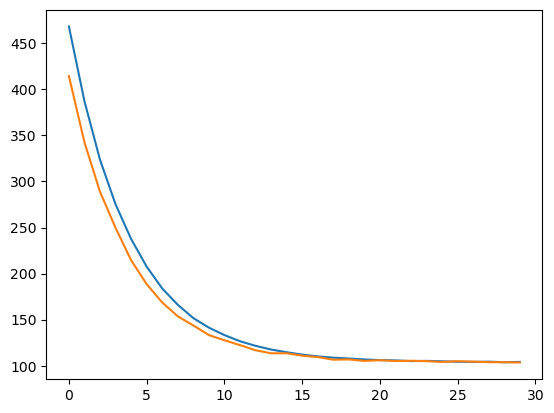

In [ ]:

plt.plot(range(len(train_losses)), train_losses, val_losses)

In [ ]:

# Parametry modelu
print(f'{model.linear.bias=}')
print(f'{model.linear.weight=}')

model.linear.bias=Parameter containing:
tensor([9.5841], requires_grad=True)
model.linear.weight=Parameter containing:
tensor([[16.4458]], requires_grad=True)
